#Project Report

## Introduction



This project implements a time series prediction model using TensorFlow. The goal is to predict future values of a time series based on historical data using a neural network architecture.





## Data Preprocessing and Model Initialization

Historical time series data is loaded from 'danel.json' and structured for neural network processing. The dataset is divided into training and test sets, TensorFlow constants are established, and a random seed is set for result consistency. Model variables are initialized, and an Adam optimizer is configured. The setup includes defining the number of epochs for the training phase.



In [8]:
import tensorflow as tf
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

# Load the JSON data containing time series information
with open('danel.json', 'r') as file:
    data = json.load(file)

# Extract the weekly adjusted time series data
time_series_data = data['Weekly Adjusted Time Series']

# Convert the time series data to a list of lists (each sublist is a 7-dimensional vector)
vectors = []
for date, values in time_series_data.items():
    vectors.append([
        float(values["1. open"]),
        float(values["2. high"]),
        float(values["3. low"]),
        float(values["4. close"]),
        float(values["5. adjusted close"]),
        float(values["6. volume"]),
        float(values["7. dividend amount"])
    ])

# Convert the list of lists to a numpy array
X = np.array(vectors)

# Split the data into training and test sets with a ratio of 0.8
split = int(0.8 * len(X))
X_initial, X_tst_initial = X[:split], X[split:]

# Convert the training and test sets to TensorFlow constants with appropriate shapes
X_initial_tf = tf.constant(X_initial, shape=(split, 7, 1))
X_tst_initial_tf = tf.constant(X_tst_initial, shape=(len(time_series_data) - split, 7, 1))

# Set the random seed for reproducibility
tf.random.set_seed(16)

# Initialize variables A, B, C, and D as trainable TensorFlow variables with random normal distributions
A = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='A', trainable=True)
B = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='B', trainable=True)
C = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='C', trainable=True)
D = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='D', trainable=True)

# Define the Adam optimizer with a learning rate of 0.01
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Define the number of epochs for training
epochs = range(50)


## Model Function Overview

The `model` function is designed to train a neural network for time series prediction. It initializes lists to track error metrics, iterates through epochs to train the model using gradient descent, and calculates mean squared error (MSE) and mean absolute error (MAE) for both training and test sets. The function employs TensorFlow's automatic differentiation capabilities to update model parameters and records the error metrics after each epoch. Finally, it returns the compiled lists of MSE and MAE values, providing insight into the model's performance over time.




In [9]:
def model(X_train, X_test, A, B, C, D, optimizer, epochs, split):
    # Lists to store mean squared error (MSE) and mean absolute error (MAE) values for training and test sets
    MSE_values = []
    MAE_values = []
    MSE_test_values = []
    MAE_test_values = []

    # Loop through each epoch
    for e in epochs:
        # Initialize hidden state variables for training and test sets
        h = tf.Variable(np.zeros_like(X_train))
        h_tst = tf.Variable(np.zeros_like(X_test))

        # Begin gradient tape to record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Initialize loss variables
            loss = 0
            loss_test = 0
            MAE = 0
            MAE_tst = 0

            # Iterate through each time step in the training set
            for t in range(1, split - 1):  # Adjust loop range
                # Forward pass through the model
                y_t = C @ tf.nn.relu(A @ h[t-1] + B @ X_train[t-1]) + D @ X_train[t]
                h[t + 1].assign(tf.nn.relu(A @ h[t] + B @ X_train[t]))

                # Calculate loss and MAE for training set
                loss += tf.reduce_sum(tf.square(X_train[t + 1] - y_t)) / split
                MAE += tf.reduce_sum(tf.abs(X_train[t + 1] - y_t)) / split

            # Compute gradients and apply optimization step
            gradients = tape.gradient(loss, [A, B, C, D], unconnected_gradients=tf.UnconnectedGradients.ZERO)
            optimizer.apply_gradients(zip(gradients, [A, B, C, D]))

            # Initialize the first hidden state for the test set
            h_tst[0].assign(h[-1])

            # Iterate through each time step in the test set
            for t in range(1, len(X_test) - 1):  # Adjust loop range
                # Forward pass through the model for the test set
                y_t = C @ tf.nn.relu(A @ h_tst[t-1] + B @ X_test[t-1]) + D @ X_test[t]
                h_tst[t + 1].assign(tf.nn.relu(A @ h_tst[t] + B @ X_test[t]))

                # Calculate loss and MAE for the test set
                loss_test += tf.reduce_sum(tf.square(X_test[t + 1] - y_t)) / split
                MAE_tst += tf.reduce_sum(tf.abs(X_test[t + 1]- y_t)) / split

        # Record MSE and MAE for training and test sets for the current epoch
        MSE_train = loss
        MSE_values.append(MSE_train.numpy())

        MSE_test = loss_test
        MSE_test_values.append(MSE_test.numpy())

        MAE_train = MAE   # Adjust divisor
        MAE_values.append(MAE_train.numpy())

        MAE_test = MAE_tst  # Adjust divisor
        MAE_test_values.append(MAE_test.numpy())

    # Return lists containing MSE and MAE values for training and test sets
    return MSE_values, MAE_values, MSE_test_values, MAE_test_values


## Model Training Execution

The code snippet executes the `model` function, which trains the neural network on the initial training set and evaluates it on the initial test set. It captures the mean squared error (MSE) and mean absolute error (MAE) for both sets, providing a quantitative measure of the model's predictive accuracy. The printed output of MSE and MAE values serves as a record of the model's performance metrics after training.


In [10]:
# Call the model function to train the model and obtain MSE and MAE values for the initial training and test sets
MSE_train_initial, MAE_train_initial, MSE_test_initial, MAE_test_initial = model(X_initial_tf, X_tst_initial_tf, A, B, C, D, optimizer, epochs, split)

# Print the MSE and MAE values for the initial training and test sets
print(MSE_train_initial)
print(MAE_train_initial)
print(MSE_test_initial)
print(MAE_test_initial)


[4316623342633289.0, 4111314723591939.0, 3884975501429472.0, 3699814304995318.5, 3498139877346307.0, 3309504646956201.5, 3140714162304965.5, 3005898827464140.5, 2953103898018383.5, 2775744075862977.5, 2665942130340079.0, 2583721138855830.5, 2477563151905587.0, 2397903482344086.5, 2298021521328502.0, 2258067718370624.0, 2185632381865248.8, 2072730871709219.5, 2008605195651674.5, 1925620627903723.0, 1835080948488233.0, 1801193192921458.2, 1756983477972914.0, 1693424424576271.2, 1662570657904183.2, 1632899340725865.5, 1595635515519065.2, 1568429564235515.5, 1528576507324765.0, 1474515945071521.2, 1438544214680748.2, 1398641458305208.5, 1335070863186367.8, 1289967330750961.2, 1252466347300944.2, 1233047289814970.0, 1200158042220916.8, 1175787503896972.8, 1142669608115832.8, 1110147957156770.1, 1081180533382384.1, 1044048710324361.6, 1026943453505234.9, 990488209835774.4, 957949125592543.4, 914821985162844.8, 891510611103131.1, 855145959482176.8, 827345682351246.1, 795465956984458.4]
[13206

## Standardization and Neural Network Setup

The code standardizes the time series data using `StandardScaler` to ensure each feature contributes equally to the model. Standardized data is then shaped into TensorFlow constants for neural network compatibility. A random seed is set for reproducible results, and neural network variables are initialized with random values. An Adam optimizer is defined to fine-tune the model, and the training is set to run for 50 epochs.






In [13]:
# Initialize the StandardScaler to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and test data
X = scaler.fit_transform(X_initial)
X_tst = scaler.fit_transform(X_tst_initial)

# Convert the standardized data to TensorFlow constants with appropriate shapes
X = tf.constant(X, shape=(split, 7, 1))
X_tst = tf.constant(X_tst, shape=(len(time_series_data) - split, 7, 1))

# Set the random seed for reproducibility
tf.random.set_seed(16)

# Initialize variables A, B, C, and D as trainable TensorFlow variables with random normal distributions
A = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='A', trainable=True)
B = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='B', trainable=True)
C = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='C', trainable=True)
D = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='D', trainable=True)

# Define the Adam optimizer with a learning rate of 0.01
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Define the number of epochs for training
epochs = range(50)


## Model Training and Evaluation

The `model` function is invoked with the standardized training and test sets to train the neural network. It returns the mean squared error (MSE) and mean absolute error (MAE) for both sets, which are essential metrics for assessing the model's accuracy. The results are printed, providing a clear view of the model's performance on both the training and test data after standardization.







In [14]:
# Call the model function to train the model and obtain MSE and MAE values for the standardized training and test sets
MSE_train_std, MAE_train_std, MSE_test_std, MAE_test_std = model(X, X_tst, A, B, C, D, optimizer, epochs, split)

# Print the MSE and MAE values for the standardized training and test sets
print(MSE_train_std)
print(MAE_train_std)
print(MSE_test_std)
print(MAE_test_std)


[389.21372613519486, 361.468655213629, 322.4279707404684, 286.698012557981, 257.8548878080748, 231.005476898803, 208.70283809860862, 189.10869644236624, 172.88928774046798, 162.13646269774472, 151.20399609504776, 141.45046717430876, 132.41723863826783, 124.81545964553084, 116.98197479636568, 109.89333414032377, 104.0848428535034, 98.28350128001605, 92.9658413119888, 88.03992966276313, 83.58293733806504, 79.46647257731298, 75.6088774926695, 71.98516829472686, 68.92602450410403, 65.91082268389846, 62.79957054349987, 60.08210842719178, 57.74318843338465, 55.56536667740243, 53.4574460274043, 51.39775851068606, 49.41217676474144, 47.693542509360036, 46.05438486340685, 44.50257642196277, 43.109016078810406, 41.8021800821741, 40.5195662521276, 39.28792258072013, 38.13189256915581, 37.00757006258292, 35.913734310917775, 34.91047512244956, 33.93950568732966, 33.02571881377044, 32.14460784872899, 31.269562569286695, 30.42412137472852, 29.606619610335688]
[36.88368706815011, 35.54862451021539, 33

## Regularization in Neural Network Training

The code configures a neural network with random initialization and sets a random seed to ensure reproducibility. It introduces a model function with L1 and L2 regularization to mitigate overfitting. During training, the function calculates mean squared error (MSE) and mean absolute error (MAE) for both training and test sets, adjusting weights using gradient descent. The function concludes by printing the MSE and MAE, indicating the effectiveness of regularization on the model's performance.





In [15]:
# Set the random seed for reproducibility
tf.random.set_seed(16)

# Initialize variables A, B, C, and D as trainable TensorFlow variables with random normal distributions
A = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='A', trainable=True)
B = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='B', trainable=True)
C = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='C', trainable=True)
D = tf.Variable(tf.random.normal(shape=(7, 7), dtype='float64'), name='D', trainable=True)

# Define the Adam optimizer with a learning rate of 0.01
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Define a new model function with L1 and L2 regularization
def model_l(X_train, X_test, A, B, C, D, optimizer, epochs, split, l1_reg=0.01, l2_reg=0.01):
    # Lists to store mean squared error (MSE) and mean absolute error (MAE) values for training and test sets
    MSE_values = []
    MAE_values = []
    MSE_test_values = []
    MAE_test_values = []

    # Loop through each epoch
    for e in epochs:
        # Initialize hidden state variables for training and test sets
        h = tf.Variable(np.zeros_like(X_train))
        h_tst = tf.Variable(np.zeros_like(X_test))

        # Begin gradient tape to record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # Initialize loss variables
            loss = 0
            loss_test = 0
            MAE = 0
            MAE_tst = 0

            # Iterate through each time step in the training set
            for t in range(1, split - 1):
                # Forward pass through the model
                y_t = C @ tf.nn.relu(A @ h[t-1] + B @ X_train[t-1]) + D @ X_train[t]
                h[t + 1].assign(tf.nn.relu(A @ h[t] + B @ X_train[t]))

                # Calculate loss and MAE for training set
                loss += tf.reduce_sum(tf.square(X_train[t + 1] - y_t)) / split
                MAE += tf.reduce_sum(tf.abs(X_train[t + 1] - y_t)) / split

            # L1 and L2 regularization
            l1_loss = tf.reduce_sum([tf.reduce_sum(tf.abs(param)) for param in [A, B, C, D]])
            l2_loss = tf.reduce_sum([tf.reduce_sum(tf.square(param)) for param in [A, B, C, D]])
            loss += l1_reg * l1_loss + l2_reg * l2_loss

            # Compute gradients and apply optimization step
            gradients = tape.gradient(loss, [A, B, C, D], unconnected_gradients=tf.UnconnectedGradients.ZERO)
            optimizer.apply_gradients(zip(gradients, [A, B, C, D]))
            h_tst[0].assign(h[-1])

            # Iterate through each time step in the test set
            for t in range(1, len(X_test) - 1):
                # Forward pass through the model for the test set
                y_t = C @ tf.nn.relu(A @ h_tst[t-1] + B @ X_test[t-1]) + D @ X_test[t]
                h_tst[t + 1].assign(tf.nn.relu(A @ h_tst[t] + B @ X_test[t]))

                # Calculate loss and MAE for the test set
                loss_test += tf.reduce_sum(tf.square(X_test[t + 1] - y_t)) / split
                MAE_tst += tf.reduce_sum(tf.abs(X_test[t + 1]- y_t)) / split

        # Record MSE and MAE for training and test sets for the current epoch
        MSE_train = loss
        MSE_values.append(MSE_train.numpy())

        MSE_test = loss_test
        MSE_test_values.append(MSE_test.numpy())

        MAE_train = MAE
        MAE_values.append(MAE_train.numpy())

        MAE_test = MAE_tst
        MAE_test_values.append(MAE_test.numpy())

    # Return lists containing MSE and MAE values for training and test sets
    return MSE_values, MAE_values, MSE_test_values, MAE_test_values

# Call the model_l function to train the model with L1 and L2 regularization
MSE_train_values_l, MAE_train_values_l, MSE_test_values_l, MAE_test_values_l = model_l(X, X_tst, A, B, C, D, optimizer, epochs, split, l1_reg=0.01, l2_reg=0.01)

# Print the MSE and MAE values for the model with L1 and L2 regularization
print(MSE_train_values_l)
print(MAE_train_values_l)
print(MSE_test_values_l)
print(MAE_test_values_l)


[392.68221437891475, 364.8477097517641, 325.8873267263584, 290.1377871356555, 261.2545308740992, 234.3851282570541, 212.04750388928062, 192.3210775279621, 176.0183519747023, 165.4150374521087, 154.51497101387898, 144.66545092350833, 135.55943276193125, 127.99268379517606, 120.12647751948609, 112.9625200436084, 107.09616110142441, 101.36867765915554, 95.97520334677934, 91.10400089543418, 86.67810113908989, 82.48700289907798, 78.79030590690951, 75.05222483687842, 72.18813470179761, 68.92785231647558, 65.95587138060719, 63.11340385670828, 60.804092515910355, 58.53451159661238, 56.473488435447685, 54.34615520401845, 52.44393271773691, 50.702638839399974, 49.044356082171895, 47.5016209750932, 46.06758378292424, 44.6715589673882, 43.39292828143574, 42.147364125417425, 40.97096614386257, 39.88159567010217, 38.7878352118357, 37.84099322766148, 36.89318650604524, 35.949222254737805, 35.02923782564545, 34.12668047197136, 33.25888331391288, 32.4350303021973]
[36.88368706815011, 35.5427247997618, 

## Visualization of Training Metrics

The provided code defines a function to visualize the training metrics of a neural network. It plots the mean squared error (MSE) and mean absolute error (MAE) for both training and test datasets across epochs. The function creates two subplots: one for MSE and another for MAE, with distinct labels for initial, standardized, and regularized data. This visual representation helps in assessing the model's learning progress and the impact of data preprocessing and regularization techniques on its performance.






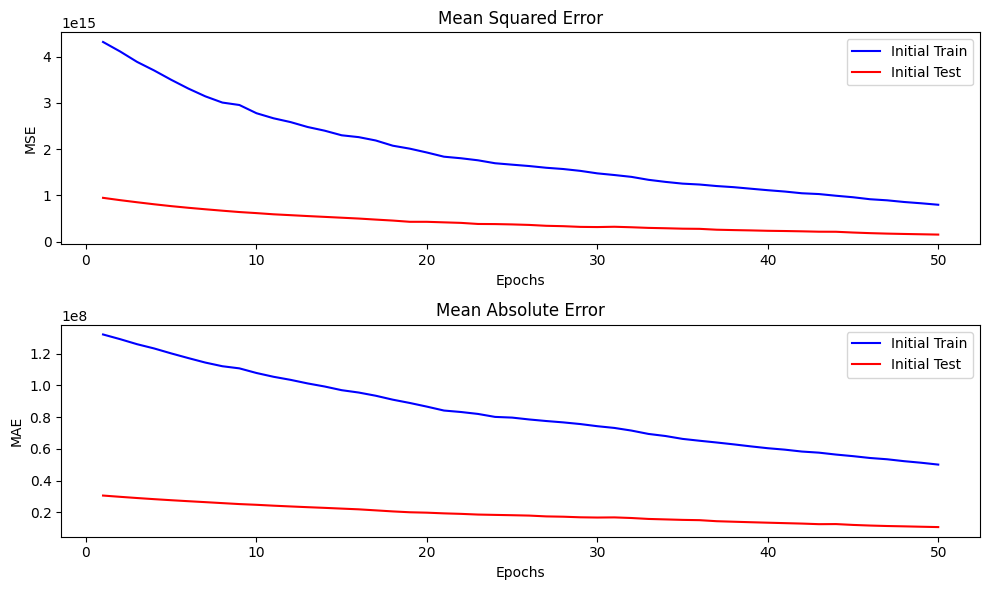

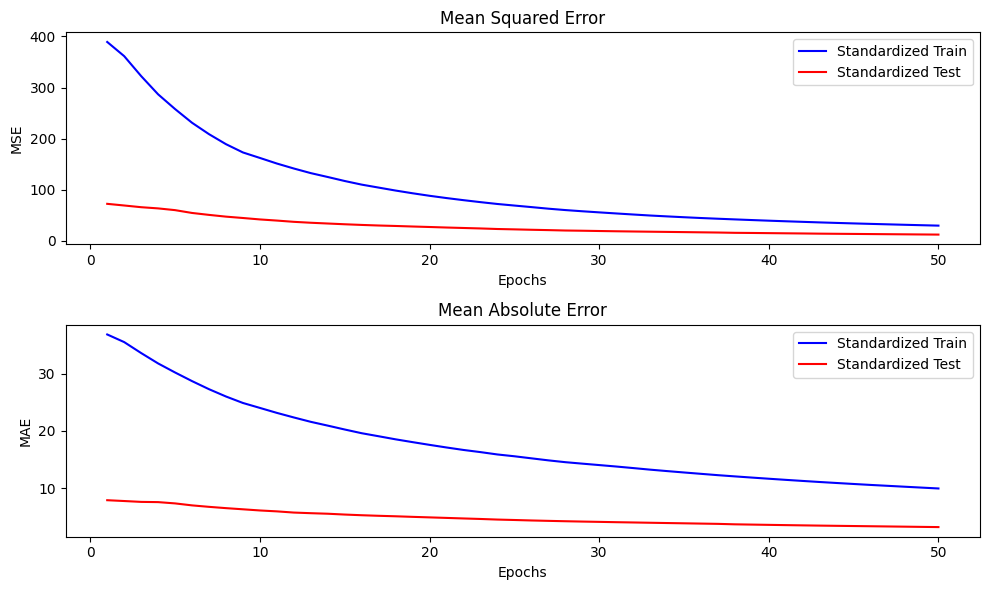

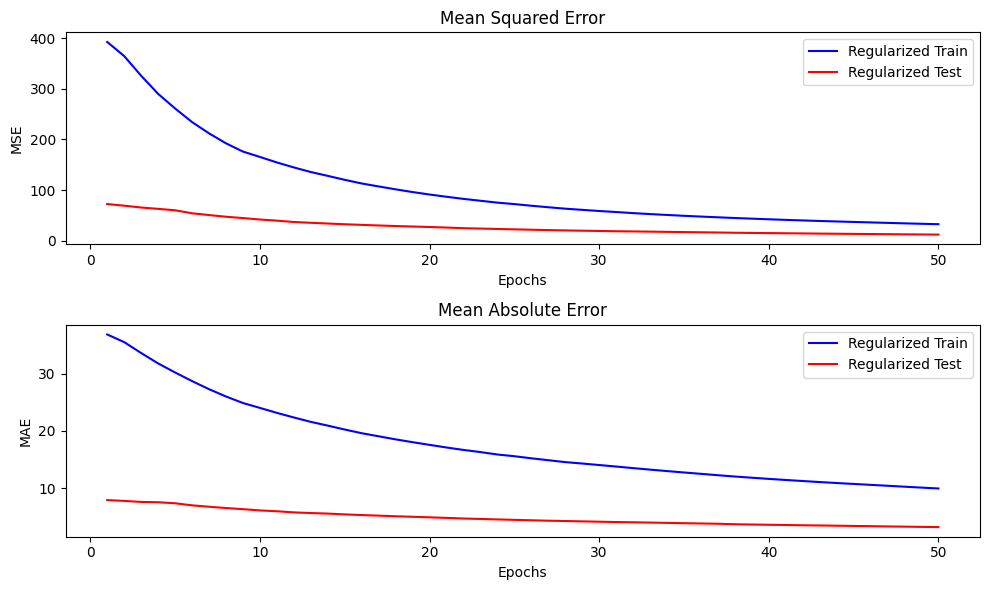

In [16]:
import matplotlib.pyplot as plt

# Function to plot the training process
def plot_training_process(MSE_train, MAE_train, MSE_test, MAE_test, label_train, label_test):
    # Generate a range of epochs for plotting
    epochs = range(1, len(MSE_train) + 1)

    # Create a figure and set its size
    plt.figure(figsize=(10, 6))

    # Plot MSE
    plt.subplot(2, 1, 1)
    plt.plot(epochs, MSE_train, 'b', label=label_train)  # Plot MSE for training data
    plt.plot(epochs, MSE_test, 'r', label=label_test)    # Plot MSE for test data
    plt.title('Mean Squared Error')  # Set title for MSE plot
    plt.xlabel('Epochs')             # Set label for x-axis
    plt.ylabel('MSE')                 # Set label for y-axis
    plt.legend()                     # Add legend to the plot

    # Plot MAE
    plt.subplot(2, 1, 2)
    plt.plot(epochs, MAE_train, 'b', label=label_train)  # Plot MAE for training data
    plt.plot(epochs, MAE_test, 'r', label=label_test)    # Plot MAE for test data
    plt.title('Mean Absolute Error')   # Set title for MAE plot
    plt.xlabel('Epochs')               # Set label for x-axis
    plt.ylabel('MAE')                   # Set label for y-axis
    plt.legend()                       # Add legend to the plot

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()         # Display the plot

# Plotting the training process for initial and standardized data, and with L1 regularization
plot_training_process(MSE_train_initial, MAE_train_initial, MSE_test_initial, MAE_test_initial, 'Initial Train', 'Initial Test')
plot_training_process(MSE_train_std, MAE_train_std, MSE_test_std, MAE_test_std, 'Standardized Train', 'Standardized Test')
plot_training_process(MSE_train_values_l, MAE_train_values_l, MSE_test_values_l, MAE_test_values_l, 'Regularized Train', 'Regularized Test')


## Conclusion
After comparing the performance metrics of the models with and without regularization, it was revealed that the differences between the two are small and insignificant. Both models exhibit similar behavior in terms of mean squared error (MSE) and mean absolute error (MAE) on both the training and test sets. Therefore, the choice between using regularization or not may not significantly impact the model's predictive capabilities in this scenario.

In practical terms, this suggests that the additional computational complexity introduced by regularization may not be necessary for this particular dataset and problem. However, further experimentation and evaluation on different datasets and model architectures may provide more insights into the effectiveness of regularization techniques for time series prediction tasks.